In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
def do_model(data, stock):

    print(f'Stock: {stock}')
    stock_data = pd.read_csv(data, index_col=0, parse_dates=True)

    # Use MinMaxScaler to scale the numerical features to a range of 0 to 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data)

    # Create a new DataFrame with the scaled data and the original column names
    scaled_df = pd.DataFrame(scaled_data, index=stock_data.index, columns=stock_data.columns)

    close_scaler = MinMaxScaler()
    scaled_close_data = close_scaler.fit_transform(stock_data[['Close']])

    # Determine the sequence length (window) for input to the CNN
    sequence_length = 5  # Example: Use the past 5 days to predict the next day's close

    test_start = pd.Timestamp('2019-02-01')
    test_end = pd.Timestamp('2019-04-29')
    y_test_full = stock_data['Close'][test_start:test_end]
    y_test_dates = y_test_full.index.to_numpy()
    y_test_full = y_test_full.to_numpy()

    test_start = scaled_df.index.get_loc(test_start)
    test_end = scaled_df.index.get_loc(test_end)

    # Create a function to generate sequences of data for training
    def create_sequences(data, seq_length, target_col_index):
        train_sequences = []
        train_targets = []
        sequences = []
        targets = []
        for i in range(test_start - seq_length + 1):
          seq = data[i:i + seq_length]
          target = scaled_close_data[i + seq_length]
          train_sequences.append(seq)
          train_targets.append(target)
        for i in range(test_start, test_end - seq_length + 1):
            # ex: for i=0 and seq_length=5, this will be sequence from 0 to 5
            seq = data[i:i + seq_length]
            # target is the data point the day after this sequence
            target = scaled_close_data[i + seq_length]
            # features
            sequences.append(seq)
            # labels
            targets.append(target)
        return np.array(train_sequences), np.array(train_targets), np.array(sequences), np.array(targets)

    # Create sequences for training and testing
    # we want to predict close price
    target_column_index = scaled_df.columns.get_loc("Close")  # The index of the 'Close' column
    # getting features (sequences) and labels (closing prices)
    X_train, y_train, X_test, y_test = create_sequences(scaled_data, sequence_length, target_column_index)

    # CNN
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(sequence_length, 6)),  # Convolutional layer
        Flatten(),  # Flattening the output for dense layer
        Dense(64, activation='relu'),  # Dense layer
        Dropout(0.2),  # Dropout layer for regularization
        Dense(1)  # Output layer for predicting the next day's closing price
    ])

    # Compile the model with Mean Squared Error as the loss function and Adam optimizer
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model on the training data with validation on the testing data
    model.fit(
        X_train, y_train,
        epochs=50,  # Maximum epochs
        batch_size=32,  # Batch size for training
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],  # Early stopping callback
        verbose=1  # Display training progress
    )

    # predicting
    y_pred = model.predict(X_test)

    y_pred_rescaled = close_scaler.inverse_transform(y_pred)
    y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

    # mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r_squared = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f"R-squared: {r_squared:.4f}")
    rmse_price = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE (Dollars): {rmse_price}')
    print(f'RMSE (Scaled by min-max scaler): {rmse_scaled}')

    model.summary()  # Display the CNN model summary
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_dates, y_test_full, label='Actual Closing Price', marker='o')
    plt.plot(stock_data.index[-len(y_pred_rescaled):], y_pred_rescaled, label='Predicted Closing Price', linestyle='--', marker='x')
    plt.xticks(fontsize='9')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.title(f'Stock Prediction for {stock}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return r_squared, rmse_price

Stock: AAPL
Epoch 1/50
23/23 [==============================] - 1s 10ms/step - loss: 0.1998 - val_loss: 0.0040
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0058
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0018
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 4.8079e-04
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 5.0835e-04
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 7.8159e-04
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 4.2919e-04
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 5.9193e-04
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0047 - val

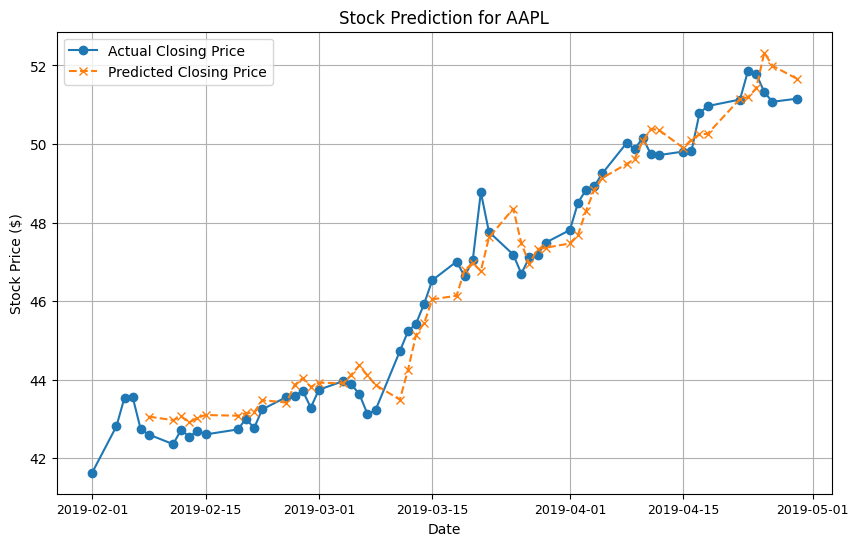

Stock: AMZN
Epoch 1/50
23/23 [==============================] - 2s 14ms/step - loss: 0.0839 - val_loss: 0.0035
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0036
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 5.8268e-04
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 9.5104e-04
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 6.2664e-04
Epoch 9/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 10/50
2/2 [==============================] - 0s 6ms/step
R-squared: 0.8866
RMSE (Dollar

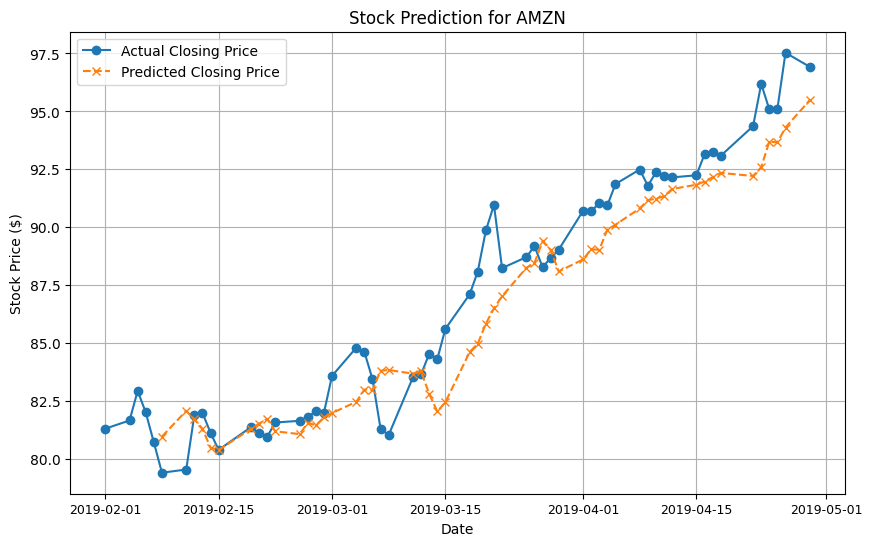

Stock: META
Epoch 1/50
23/23 [==============================] - 1s 9ms/step - loss: 0.0723 - val_loss: 0.0052
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0030
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0017
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 10/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 1

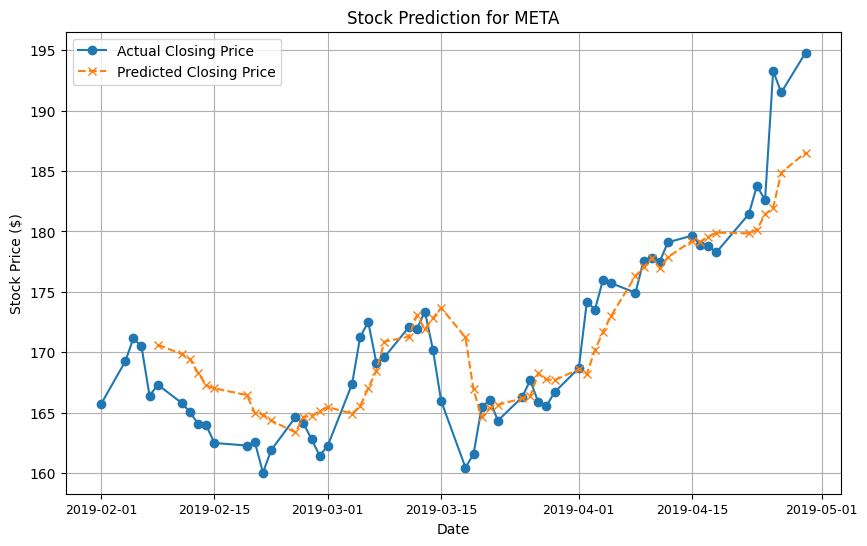

Stock: MSFT
Epoch 1/50
23/23 [==============================] - 1s 9ms/step - loss: 0.0919 - val_loss: 0.0012
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/50
2/2 [==============================] - 0s 5ms/step
R-squared: 0.7956
RMSE (Dollars): 2.7635243654593857
RMSE (Scaled by min-max scaler): 0.03392491408725281
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 1, 32)             992       
                                                                 
 flatten_11 (Flatten)        (None, 32)    

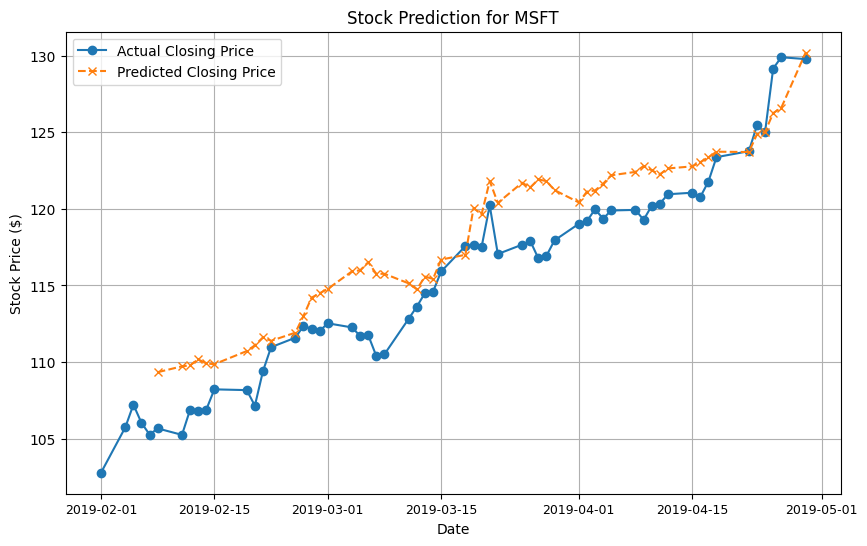




AAPL
----
R-squared: 0.9626811367930148
RMSE: 0.6000806061727768

AMZN
----
R-squared: 0.8865845284031475
RMSE: 1.754127786061382

META
----
R-squared: 0.785011603574897
RMSE: 3.8541572299371256

MSFT
----
R-squared: 0.7956442735478685
RMSE: 2.7635243654593857



In [ ]:
files = ['raw_aapl.csv', 'raw_amzn.csv', 'raw_meta.csv', 'raw_msft.csv']
stocks = ['AAPL', 'AMZN', 'META', 'MSFT']
r_squared_arr = []
rmse_arr = []
for i in range(len(files)):
    r_squared, rmse = do_model(files[i], stocks[i])
    r_squared_arr.append(r_squared)
    rmse_arr.append(rmse)

print("\n\n")

for i in range(len(rmse_arr)):
    print(f'{stocks[i]}\n----\nR-squared: {r_squared_arr[i]}\nRMSE: {rmse_arr[i]}\n')
